In [2]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import argparse
from functools import partial
from math import ceil
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils

from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm
import numpy as np
from torch.distributions import Normal, Uniform
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-30 08:38:27.049368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 08:38:27.049417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 08:38:27.049446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 08:38:27.056992: I tensorflow/core/platform/cpu_feature_guard.cc:182]

In [3]:
class ColoredMNIST(Dataset):
    """Wrap torchvision MNIST and produce 3-channel colored images (float tensors).
    """    
    def __init__(self, root: str, train: bool = True):
        self.mnist = datasets.MNIST(root=root, train=train, download=True)
        self.weights = torch.tensor([0.6, 0.35, 0.05])
        self.centers = torch.tensor([0.7, 0.5, 0.1])
        self.stddevs = torch.tensor([0.08, 0.015, 0.02])

    def get_background_gmm(self):
        mix = Categorical(self.weights)
        comp = Normal(self.centers, self.stddevs)
        gmm = MixtureSameFamily(mix, comp)
        return gmm
    
    def colorize(self, x):
        has_batch_dim = x.ndim == 4
        if not has_batch_dim:
            x = x.unsqueeze(0)
        assert x.shape[1:] == (1, 28, 28), f"expected batch of 1x28x28 input to colorize but got {x.shape}"
        color_dist = self.get_background_gmm()
        background_color = color_dist.sample(torch.Size([x.shape[0], 3]))
        foreground_color = background_color # color_dist.sample(torch.Size([x.shape[0], 3]))
        x_colored = (1-x.repeat(1, 3, 1, 1))*background_color[..., None, None] + x.repeat(1, 3, 1, 1) * ((foreground_color[..., None, None] + 0.5) % 1)
        if not has_batch_dim:
            x_colored = x_colored.squeeze(0)
        return x_colored
    
    def __len__(self):
        return len(self.mnist)
    
    
    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img = transforms.ToTensor()(img)
        img_colorized = self.colorize(img)
        return normalize(img_colorized), label

    def decolorize(self, x_colored):
        def detect_colors(x_data):
            background_colors = torch.mean(x_data[:,:,:,0],-1)
            return background_colors
        x_c = x_colored.reshape(-1,3,28,28)
        c = detect_colors(x_c)
        c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
        x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
        return x_dc.abs(), c


def make_dataloaders(root: str, batch_size: int, num_workers: int):
    train_ds = ColoredMNIST(root=root, train=True)
    test_ds = ColoredMNIST(root=root, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

def sample_grid(model, scheduler, device, n_steps=100, n_row=8, n_col=8, guidance_labels=None):
    model.eval()
    num_images = n_row * n_col
    # start from random noise
    sample_shape = (num_images, 3, 28, 28)
    sample = torch.randn(sample_shape, device=device)
    # configure scheduler timesteps for sampling
    if n_steps is not None:
        scheduler.set_timesteps(n_steps)

    timesteps = scheduler.timesteps  # already in the right order

    with torch.no_grad():
        for t in tqdm(timesteps, desc=f"sampling ({len(timesteps)} steps)"):
            t_batch = torch.full((num_images,), t, device=device, dtype=torch.long)
            out = model(sample, t_batch).sample
            # scheduler step expects model_output (predicted noise) and returns a previous sample
            step = scheduler.step(model_output=out, timestep=t, sample=sample)
            sample = step.prev_sample
    # denormalize from [-1,1] to [0,1]
    sample = denormalize(sample.clamp(-1, 1))
    grid = utils.make_grid(sample, nrow=n_col)
    model.train()
    return grid

def normalize(x):
    return x*2 - 1
    
def denormalize(x):
    return (x+1)/2

def sample_timesteps_cosine(batch_size, num_steps, device):
    # Cosine weighting over t in [0, 1]
    t = torch.rand(batch_size, device=device)
    # Convert uniform t to cosine-weighted schedule
    # The function below roughly inverts the cosine schedule from Improved DDPM
    alpha_bar = torch.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
    # Map continuous t to discrete indices
    timesteps = (alpha_bar * (num_steps - 1)).long().clamp(0, num_steps - 1)
    return timesteps

    
def save_sample_grid(grid, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    utils.save_image(grid, path)


def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    ckpt = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(ckpt, path)


def train(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, _ = make_dataloaders(args.data_root, args.batch_size, args.num_workers)

    model = UNet2DModel(
        sample_size=28,
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(64, 128, 256),
        down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
        up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    ).to(device)

    scheduler = DDPMScheduler(num_train_timesteps=1000)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1.e-5)
    # Cosine annealing with warmup
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=args.lr,
        total_steps=len(train_loader) * args.epochs,
        pct_start=0.05,
        anneal_strategy='cos',
    )

    scaler = torch.cuda.amp.GradScaler(enabled=args.use_amp and torch.cuda.is_available())

    global_step = 0
    for epoch in range(1, args.epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device)
            batch_size = images.shape[0]

            noise = torch.randn_like(images)

            timesteps = sample_timesteps_cosine(batch_size, scheduler.num_train_timesteps, device)
            
            noisy_images = scheduler.add_noise(images, noise, timesteps)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=args.use_amp and torch.cuda.is_available()):
                outputs = model(noisy_images, timesteps)
                pred_noise = outputs.sample
                loss = F.smooth_l1_loss(pred_noise, noise)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            global_step += 1
            if global_step % args.log_every == 0:
                current_lr = lr_scheduler.get_last_lr()[0]
                pbar.set_postfix({'loss': float(loss.detach().cpu()), 'lr': current_lr})

            if global_step % args.save_every == 0 and args.save_every != -1:
                ckpt_path = os.path.join(args.output_dir, f"checkpoints/ckpt_step_correlated_dist_{global_step}.pt")
                save_checkpoint(model, optimizer, epoch, ckpt_path)
                grid = sample_grid(model, scheduler, device, n_row=8, n_col=8)
                save_sample_grid(grid, os.path.join(args.output_dir, f"samples/sample_correlated_dist_{global_step}.png"))

        # Save end-of-epoch checkpoint and samples periodically
        if not (epoch % 10) or (epoch == args.epochs):
            save_checkpoint(model, optimizer, epoch, os.path.join(args.output_dir, f"checkpoints/ckpt_epoch_correlated_dist_{epoch}.pt"))
            grid = sample_grid(model, scheduler, device, n_row=8, n_col=8)
            save_sample_grid(grid, os.path.join(args.output_dir, f"samples/sample_epoch_correlated_dist_{epoch}.png"))

    print("Training finished.")


# Training

In [4]:
args = type('Args', (), {
'data_root': '/home/hd/hd_hd/hd_gu452/color_mnist_eval/data',
'output_dir': './color_mnist_outputs',
'epochs': 250,
'batch_size': 128,
'lr': 2e-4,
'num_workers': 4,
'use_amp': False,
'log_every': 50,
'save_every': -1,
})()

os.makedirs(args.output_dir, exist_ok=True)
train(args)


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 319kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]
/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipykernel_1384755/148186422.py:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=args.use_amp and torch.cuda.is_available())
Epoch 1:   0%|          | 0/469 [00:00<?

Training finished.


# Sampling

In [10]:
import torch
from tqdm import tqdm

def sample_diffusion(model, scheduler, device, n_samples=1000, n_steps=None, guidance_labels=None):
    model.eval()
    sample_shape = (n_samples, 3, 28, 28)
    sample = torch.randn(sample_shape, device=device)

    # configure scheduler timesteps for sampling
    if n_steps is not None:
        scheduler.set_timesteps(n_steps)

    timesteps = scheduler.timesteps  # already in the right order

    with torch.no_grad():
        for t in tqdm(timesteps, desc=f"sampling ({len(timesteps)} steps)"):
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
            if guidance_labels is not None:
                out = model(sample, t_batch, guidance_labels).sample
            else:
                out = model(sample, t_batch).sample

            step = scheduler.step(model_output=out, timestep=t, sample=sample)
            sample = step.prev_sample

    return sample



scheduler = DDPMScheduler(num_train_timesteps=1000)
diffusion_model = UNet2DModel(
    sample_size=28,           # the target image size. For MNIST it's 28
    in_channels=3,            # colored images
    out_channels=3,           # predict noise with 3 channels
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)
generative_model_chkpt_path = "/home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/color_mnist_outputs/checkpoints/ckpt_epoch_correlated_dist_250.pt"
diffusion_model_ckpt = torch.load(generative_model_chkpt_path, map_location=device)
diffusion_model.load_state_dict(diffusion_model_ckpt["model_state_dict"])
diffusion_model.eval()

unconditional_samples = denormalize(sample_diffusion(diffusion_model, scheduler, device, n_steps=100))

sampling (100 steps): 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


In [12]:
from torch.distributions import Normal, Uniform, Laplace
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import numpy as np
from scipy.special import kl_div, rel_entr

weights = torch.tensor([0.6, 0.35, 0.05]).to(device)
centers = torch.tensor([0.7, 0.5, 0.1]).to(device)
stddevs = torch.tensor([0.08, 0.015, 0.02]).to(device)

def get_background_gmm(weights, centers, stddevs):
    mix = Categorical(weights)
    comp = Normal(centers, stddevs)
    gmm = MixtureSameFamily(mix, comp)
    return gmm

def Colorize(x_gray, c):
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_c = x_gray * ((c_image+0.5)%1 - c_image) + c_image
    return x_c

def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    return x_dc.abs(), c


def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense(x):
    return 0.6 * normal(x, 0.7, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.1, 0.02)

def compute_kl_w1_and_deviation(sample_list, n_bins=100):
    kls_r, kls_g, kls_b = [], [], []
    w1s_r, w1s_g, w1s_b = [], [], []
    dev = []

    for samples in sample_list:
        x_dc, colors = Decolorize(samples)
        max_pix = torch.max(x_dc.mean(1).reshape(-1,28*28), -1)[0].cpu()
        dev.append(torch.abs(max_pix - 1).mean().numpy())

        kls_c, w1s_c = [], []
        for c in range(3):
            H, bins = np.histogram(colors[:, c].cpu(), bins=n_bins, range=[0,1], density=True)
            bin_width = bins[1] - bins[0]
            mids = bins[:-1] + bin_width / 2

            # Discretized probabilities
            p = H * bin_width
            q = gaussian_mix_dense(mids) * bin_width
            p /= p.sum()
            q /= q.sum()

            # KL divergence
            kl_per_bin = kl_div(p, q)
            kl_per_bin = kl_per_bin[~np.logical_or(np.isnan(kl_per_bin), np.isinf(kl_per_bin))]
            kl = np.sum(kl_per_bin)
            kls_c.append(kl)

            # Wasserstein-1 distance
            C_p = np.cumsum(p)
            C_q = np.cumsum(q)
            tv_per_bin = np.abs(C_p - C_q)
            tv_per_bin = tv_per_bin[~np.logical_or(np.isnan(tv_per_bin), np.isinf(tv_per_bin))]
            w1 = np.sum(tv_per_bin) * bin_width
            w1s_c.append(w1)

        kls_r.append(kls_c[0]); kls_g.append(kls_c[1]); kls_b.append(kls_c[2])
        w1s_r.append(w1s_c[0]); w1s_g.append(w1s_c[1]); w1s_b.append(w1s_c[2])

    # Aggregate statistics
    def summarize(values):
        mean = np.mean(values)
        std = np.std(values) / np.sqrt(len(values))
        return mean, std

    kl_means = [summarize(x) for x in [kls_r, kls_g, kls_b]]
    w1_means = [summarize(x) for x in [w1s_r, w1s_g, w1s_b]]
    dev_mean, dev_std = summarize(dev)

    return kl_means, w1_means, (dev_mean, dev_std)

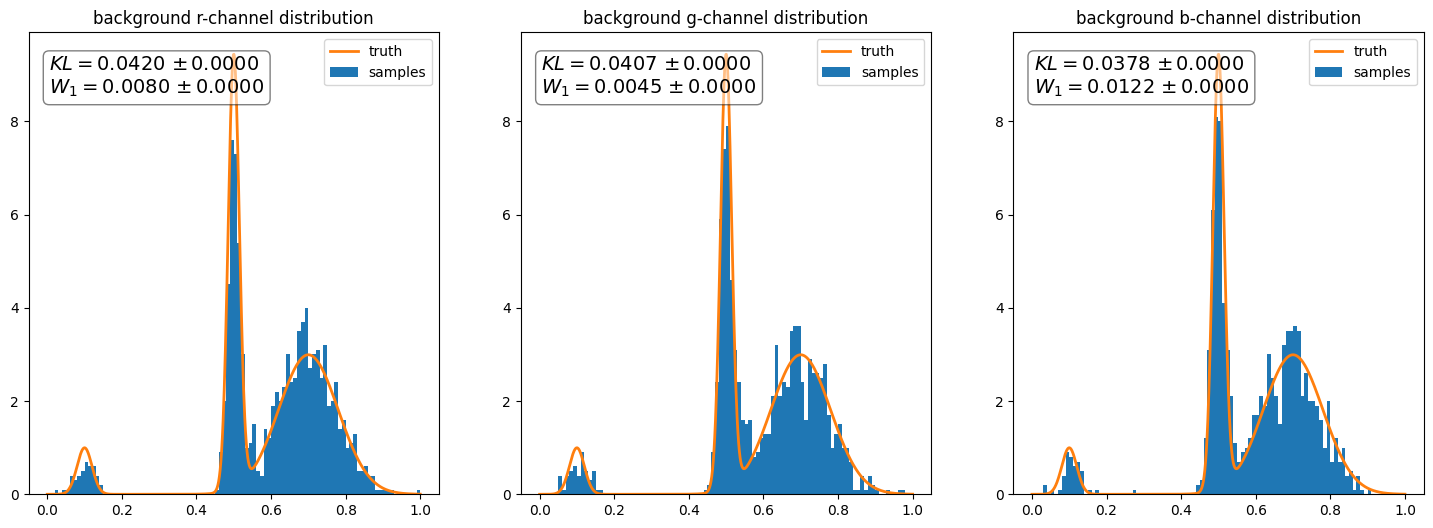

In [13]:
kl_div_all, w1_all, (dev_mean, dev_std) = compute_kl_w1_and_deviation([unconditional_samples], n_bins=100)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

textstr = r'$KL=%.4f$' % (kl_div_all[0][0], ) + r" $\pm\,%.4f$" % (kl_div_all[0][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[0][0], )  + r" $\pm\,%.4f$" % (w1_all[0][1],)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[0].set_title(r"background r-channel distribution")
H, bins = np.histogram(c[:,0].cpu(), bins=100, range=[0, 1],density=True)
axes[0].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
x = np.linspace(0,1,1000)
axes[0].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[0].legend()

axes[1].set_title(r"background g-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[1][0], ) + r" $\pm\,%.4f$" % (kl_div_all[1][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[1][0], )  + r" $\pm\,%.4f$" % (w1_all[1][1],)
axes[1].text(0.05, 0.95, textstr, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,1].cpu(), bins=100, range=[0, 1],density=True)
axes[1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[1].legend()

axes[2].set_title(r"background b-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[2][0], ) + r" $\pm\,%.4f$" % (kl_div_all[2][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[2][0], )  + r" $\pm\,%.4f$" % (w1_all[2][1],)
axes[2].text(0.05, 0.95, textstr, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,2].cpu(), bins=100, range=[0, 1],density=True)
axes[2].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[2].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[2].legend()
plt.show()

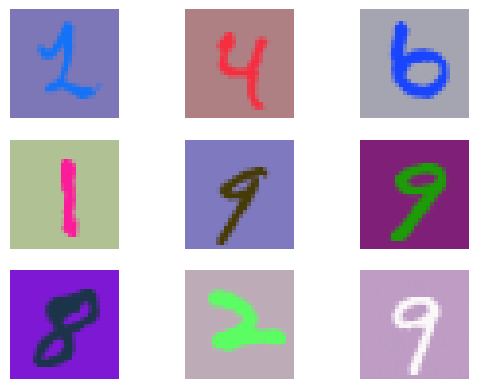

In [19]:
fig, axes = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(unconditional_samples[i*3+j].permute(1, 2, 0).cpu().detach().numpy())
        axes[i, j].axis("off")

plt.show()

In [5]:
train_loader, _ = make_dataloaders('/home/hd/hd_hd/hd_gu452/color_mnist_eval/data', 40000, 4)


samples_dataset = iter(train_loader).__next__()[0]

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
samples_dataset = denormalize(samples_dataset)

In [11]:
x_dc, c = Decolorize(samples_dataset)
kl_div_all, w1_all, (dev_mean, dev_std) = compute_kl_w1_and_deviation(samples_dataset)

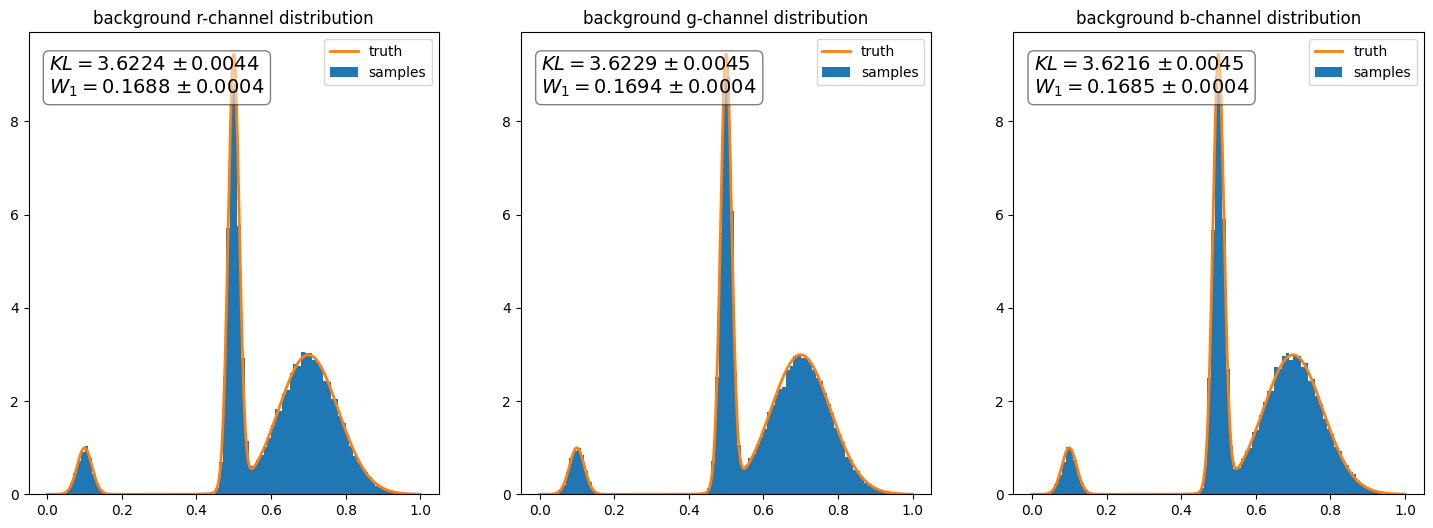

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

textstr = r'$KL=%.4f$' % (kl_div_all[0][0], ) + r" $\pm\,%.4f$" % (kl_div_all[0][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[0][0], )  + r" $\pm\,%.4f$" % (w1_all[0][1],)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[0].set_title(r"background r-channel distribution")
H, bins = np.histogram(c[:,0].cpu(), bins=100, range=[0, 1],density=True)
axes[0].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
x = np.linspace(0,1,1000)
axes[0].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[0].legend()

axes[1].set_title(r"background g-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[1][0], ) + r" $\pm\,%.4f$" % (kl_div_all[1][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[1][0], )  + r" $\pm\,%.4f$" % (w1_all[1][1],)
axes[1].text(0.05, 0.95, textstr, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,1].cpu(), bins=100, range=[0, 1],density=True)
axes[1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[1].legend()

axes[2].set_title(r"background b-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[2][0], ) + r" $\pm\,%.4f$" % (kl_div_all[2][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[2][0], )  + r" $\pm\,%.4f$" % (w1_all[2][1],)
axes[2].text(0.05, 0.95, textstr, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,2].cpu(), bins=100, range=[0, 1],density=True)
axes[2].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[2].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[2].legend()
plt.show()

In [42]:
import h5py
import torch

# with h5py.File('/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-colorMNIST/color_mnist_eval/cc_mnist/data.h5', 'r') as f:
#     test_data = torch.from_numpy(f['test_images'][:])

gmm = get_background_gmm(weights, centers, stddevs)
images = torch.ones(100000, 3, 28, 28, device=device)
colors = gmm.sample([100000, 3])
test_data = images * colors[:,:,None,None]
kl_div_all, w1_all, (dev_mean, dev_std) = compute_kl_w1_and_deviation([test_data], n_bins=100)

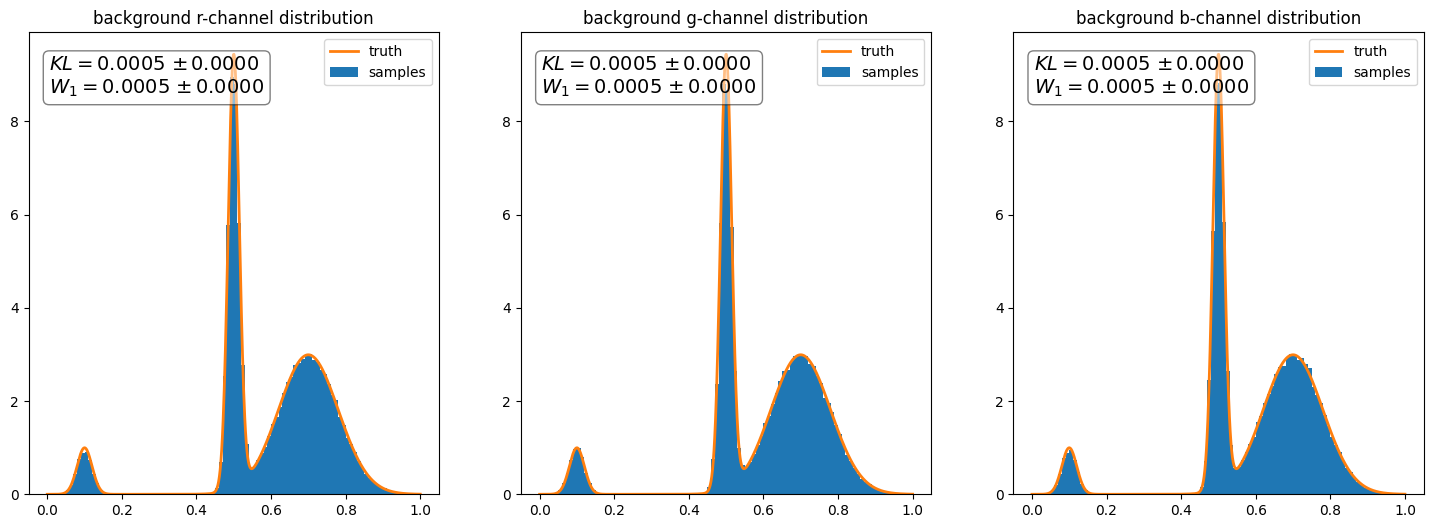

In [43]:
_, c = Decolorize(test_data)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

textstr = r'$KL=%.4f$' % (kl_div_all[0][0], ) + r" $\pm\,%.4f$" % (kl_div_all[0][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[0][0], )  + r" $\pm\,%.4f$" % (w1_all[0][1],)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[0].set_title(r"background r-channel distribution")
H, bins = np.histogram(c[:,0].cpu(), bins=100, range=[0, 1],density=True)
axes[0].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
x = np.linspace(0,1,1000)
axes[0].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[0].legend()

axes[1].set_title(r"background g-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[1][0], ) + r" $\pm\,%.4f$" % (kl_div_all[1][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[1][0], )  + r" $\pm\,%.4f$" % (w1_all[1][1],)
axes[1].text(0.05, 0.95, textstr, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,1].cpu(), bins=100, range=[0, 1],density=True)
axes[1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[1].legend()

axes[2].set_title(r"background b-channel distribution")
textstr = r'$KL=%.4f$' % (kl_div_all[2][0], ) + r" $\pm\,%.4f$" % (kl_div_all[2][1],) + "\n" + \
          r'$W_1=%.4f$' % (w1_all[2][0], )  + r" $\pm\,%.4f$" % (w1_all[2][1],)
axes[2].text(0.05, 0.95, textstr, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
H, bins = np.histogram(c[:,2].cpu(), bins=100, range=[0, 1],density=True)
axes[2].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
axes[2].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
axes[2].legend()
plt.show()